In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [24]:
datasets = ["cifar10", "mnist", "mnistm", "stl", "svhn", "syn", "usps"]
file_directory = "../../logs/resnet18/"

In [25]:
def extract_floats(s):
    # Regular expression for matching floats
    pattern = r"[-+]?[0-9]*\.?[0-9]+"
    # Find all matches in the string
    matches = re.findall(pattern, s)
    # Convert all matches to float
    floats = [float(match) for match in matches]
    return floats

In [38]:
def read_file(file_path):
    results = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if "Pruning ratio" in line:
                # Get the value after ":"
                line = line.split(":")[-1].strip()
                
                pruning_ratio = extract_floats(line.split(",")[0].strip())[0]
                results[pruning_ratio] = {}
                continue
            if "Data ratio" in line:
                # Get the value after ":"
                line = line.split(":")[2].strip()
                data_ratio = extract_floats(line.split(",")[0].strip())[0]
                data_volume = extract_floats(line.split(",")[1].strip())[0]
                accuracy = extract_floats(line.split(",")[3].strip())[0]
                results[pruning_ratio][data_ratio] = accuracy
        return results

In [27]:
seed = 1
source='usps'
for target in datasets:
    if source != target:
        org_path =  file_directory + f"original/{seed}/admm_" + source + "_to_" + target + ".log"
        org_results = read_file(org_path)

/tmp/ipykernel_28739/837116543.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, datasets.index(target) + 1)


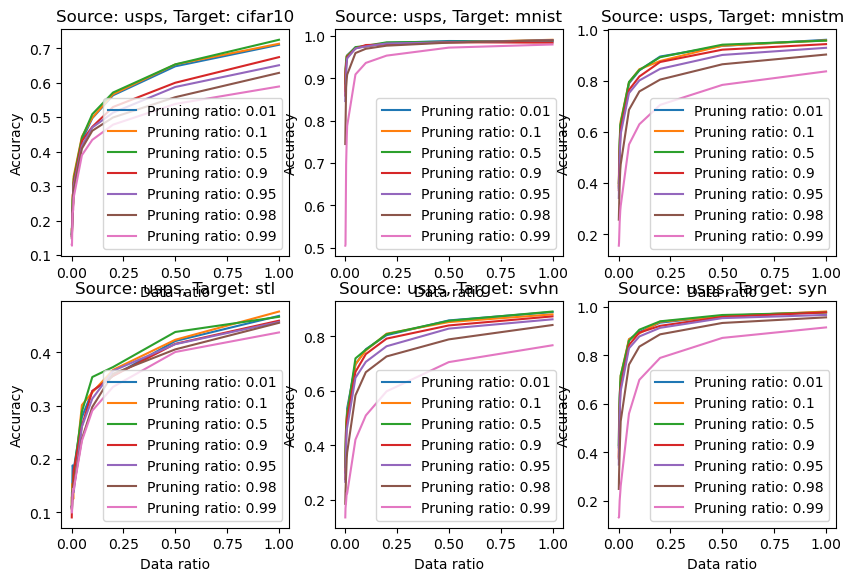

In [28]:
# visualize the curve for each pruning ratio and with each data ratio
plt.subplots(figsize=(10, 10))
for target in datasets:
    if source != target:
        org_path =  file_directory + f"original/{seed}/admm_" + source + "_to_" + target + ".log"
        org_results = read_file(org_path)
        plt.subplot(3, 3, datasets.index(target) + 1)
        for pruning_ratio in org_results:
            x = list(org_results[pruning_ratio].keys())
            y = list(org_results[pruning_ratio].values())
            plt.plot(x, y, label=f"Pruning ratio: {pruning_ratio}")
        plt.title(f"Source: {source}, Target: {target}")
        plt.xlabel("Data ratio")
        plt.ylabel("Accuracy")
        plt.legend()


In [32]:
def read_file(file_path):
    results = {}
    with open(file_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            if "Data ratio" in line:
                # Get the value after ":"
                line = line.split(":")[2].strip()
                data_ratio = extract_floats(line.split(",")[0].strip())[0]
                data_volume = extract_floats(line.split(",")[1].strip())[0]
                accuracy = extract_floats(line.split(",")[3].strip())[0]
                results[data_ratio] = accuracy
        return results
    
def log_auc(xaxis, yaxis):
    auc = 0
    for i in range(1, len(xaxis)):
        # log scale area under the curve
        auc += (np.log(xaxis[i]) - np.log(xaxis[i - 1])) * (yaxis[i] + yaxis[i - 1]) / 2
    return auc

In [33]:
# Compute the log scale area under the curve for all datasets
local = {}
for target in datasets:
    target_path = file_directory + "local/" + target + ".log"
    target_dic = read_file(target_path)
    auc = log_auc(list(target_dic.keys()), list(target_dic.values()))
    print(f"{target}: {auc}")
    local[target] = auc

cifar10: 3.5823268935873105
mnist: 6.965467036584484
mnistm: 5.122620219167711
stl: 1.5435900182042148
svhn: 4.367010713897939
syn: 4.584803735710495
usps: 5.232009656462087


In [39]:
# Compute log scale area under the curve
for target in datasets:
    if source != target:
        org_path =  file_directory + f"original/{seed}/admm_" + source + "_to_" + target + ".log"
        org_results = read_file(org_path)
        for pruning_ratio in org_results:
            x = list(org_results[pruning_ratio].keys())
            y = list(org_results[pruning_ratio].values())
            print(f"Source: {source}, Target: {target}, Pruning ratio: {pruning_ratio}, AUC: {log_auc(x, y)}")

Source: usps, Target: cifar10, Pruning ratio: 0.01, AUC: 2.825920860264301
Source: usps, Target: cifar10, Pruning ratio: 0.1, AUC: 2.8680472786839593
Source: usps, Target: cifar10, Pruning ratio: 0.5, AUC: 2.862346601839303
Source: usps, Target: cifar10, Pruning ratio: 0.9, AUC: 2.6844617677594003
Source: usps, Target: cifar10, Pruning ratio: 0.95, AUC: 2.6269500178788507
Source: usps, Target: cifar10, Pruning ratio: 0.98, AUC: 2.5476378196885143
Source: usps, Target: cifar10, Pruning ratio: 0.99, AUC: 2.395705851079238
Source: usps, Target: mnist, Pruning ratio: 0.01, AUC: 6.5932979359197255
Source: usps, Target: mnist, Pruning ratio: 0.1, AUC: 6.6015689701189535
Source: usps, Target: mnist, Pruning ratio: 0.5, AUC: 6.630722759724607
Source: usps, Target: mnist, Pruning ratio: 0.9, AUC: 6.594165339376602
Source: usps, Target: mnist, Pruning ratio: 0.95, AUC: 6.532600401106973
Source: usps, Target: mnist, Pruning ratio: 0.98, AUC: 6.3398773179069305
Source: usps, Target: mnist, Pruning

In [40]:
# Compute the difference 
for target in datasets:
    if source != target:
        org_path =  file_directory + f"original/{seed}/admm_" + source + "_to_" + target + ".log"
        org_results = read_file(org_path)
        for pruning_ratio in org_results:
            x = list(org_results[pruning_ratio].keys())
            y = list(org_results[pruning_ratio].values())
            auc = log_auc(x, y)
            print(f"Source: {source}, Target: {target}, Pruning ratio: {pruning_ratio}, AUC: {auc - local[target]}")

Source: usps, Target: cifar10, Pruning ratio: 0.01, AUC: -0.7564060333230094
Source: usps, Target: cifar10, Pruning ratio: 0.1, AUC: -0.7142796149033512
Source: usps, Target: cifar10, Pruning ratio: 0.5, AUC: -0.7199802917480076
Source: usps, Target: cifar10, Pruning ratio: 0.9, AUC: -0.8978651258279102
Source: usps, Target: cifar10, Pruning ratio: 0.95, AUC: -0.9553768757084597
Source: usps, Target: cifar10, Pruning ratio: 0.98, AUC: -1.0346890738987962
Source: usps, Target: cifar10, Pruning ratio: 0.99, AUC: -1.1866210425080723
Source: usps, Target: mnist, Pruning ratio: 0.01, AUC: -0.3721691006647587
Source: usps, Target: mnist, Pruning ratio: 0.1, AUC: -0.3638980664655307
Source: usps, Target: mnist, Pruning ratio: 0.5, AUC: -0.33474427685987695
Source: usps, Target: mnist, Pruning ratio: 0.9, AUC: -0.3713016972078824
Source: usps, Target: mnist, Pruning ratio: 0.95, AUC: -0.43286663547751125
Source: usps, Target: mnist, Pruning ratio: 0.98, AUC: -0.6255897186775536
Source: usps, T